In [1]:
import math
import numba
import numpy as np

# FIXME - rewrite in pytorch
from autograd import numpy as np_ag
from autograd import elementwise_grad, grad, jacobian

import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
DEFAULT_PARAMS = np.array([
    -1.777,  # log10epsilon
    11.514,  # log10M1
    -1.412,  # alpha
    0.316,  # gamma
    3.508  # delta
])


def log10mstar_mpeak(mvir_peak, params):
    """M*(Mvir_peak) from Behroozi et a. (2012, 1207.6105), Eq. 3.
    
    Only valid at z = 0.
    
    Parameters
    ----------
    mvir_peak : np.array
        The peak virial mass of the subhalo.
    params : np.array
        An array of the parameters in the order 
        [log10epsilon, log10M1, alpha, gamma, delta].
    
    Returns
    -------
    log10mstar : np.array
        The base-10 log of the stellar mass.
    """
    log10epsilon = params[0]
    log10M1 = params[1]
    alpha = params[2]
    gamma = params[3]
    delta = params[4]
    def _f(x):
        return (
            -np_ag.log10(np_ag.power(10, alpha * x) + 1) + 
            delta * 
            np_ag.power(np_ag.log10(1 + np_ag.exp(x)), gamma) / 
            (1.0 + np_ag.exp(np_ag.power(10, -x))))
    log10_mh_m1 = np_ag.log10(mvir_peak) - log10M1
    log10_mstar = log10epsilon + log10M1 + _f(log10_mh_m1) - _f(0)
    return log10_mstar

# this computes the derivative we need of the model wrt the parameters
jac_grad_delta = jacobian(log10mstar_mpeak, 1)

In [3]:
# output here is the deriv of log10Mstar for the ith object wrt to the jth
# parameter as jac[i, j]
jac = jac_grad_delta(np.array([1e12, 1e10]), DEFAULT_PARAMS)
print(jac)

# fancy right?

[[ 1.          0.04450711 -0.0829992  -0.19590005  0.13438049]
 [ 1.         -0.40179259  1.50305522  0.77506218 -0.18403413]]


In [24]:
@numba.njit
def kernel_hist_with_derivs(log10mstar, log10mstar_jac, bins, sigma):
    """Compute a histogram of the input stellar masses along with the 
    derivatives of this histogram using the input jacobian.
    
    Parameters
    ----------
    log10mstar : np.array, shape (n_data,)
        The input stellar masses to histogram.
    log10mstar_jac : np.array, shape (n_data, n_params)
        The jacobian derivs of the input stellar masses wrt the params.
    bins : np.array, shape (n_bins+1,)
        An array of the bin edges.
    sigma : float or np.array of shape (n_data,)
        The width of the Gaussian kernel to use for the bins. Should be 
        roughly the scatter in the stellar to halo mass relation with 
        any observational errors. FIXME: We need to output a derivative 
        wrt this as well.
    
    Returns
    -------
    hist : np.array, shape (n_bins,)
        The output histogram.
    hist_jac : np.array, shape (n_bins, n_params)
        The derivatives of the histogram bins wrt the params.
    """
    n_bins = bins.shape[0]-1
    n_params = log10mstar_jac.shape[1]
    n_data = log10mstar.shape[0]
    
    hist = np.zeros(n_bins)
    hist_jac = np.zeros((n_bins, n_params))

    sigma_sqrt2 = sigma * math.sqrt(2)
    sigma_sqrt2pi = sigma_sqrt2 * math.sqrt(math.pi)

    for i in range(n_data):
        x = log10mstar[i]

        z = (x - bins[0]) / sigma_sqrt2
        last_cdf = (1 + math.erf(z)) / 2
        last_cdf_deriv = math.exp(-z*z) / sigma_sqrt2pi

        for j in range(n_bins):
            z = (x -  bins[j+1]) / sigma_sqrt2
            new_cdf = (1 + math.erf(z)) / 2
            new_cdf_deriv = math.exp(-z*z) / sigma_sqrt2pi

            # get the hist weight
            weight = last_cdf - new_cdf
            hist[j] += weight
            
            # do the derivs
            for k in range(n_params):
                hist_jac[j, k] += (last_cdf_deriv - new_cdf_deriv) * log10mstar_jac[i, k]

            last_cdf = new_cdf
            last_cdf_deriv = new_cdf_deriv
    
    return hist, hist_jac

In [25]:
mpeak = np.array([1e12, 1e14])
vals = log10mstar_mpeak(mpeak, DEFAULT_PARAMS)
jac = jac_grad_delta(mpeak, DEFAULT_PARAMS)

h, jac_h = kernel_hist_with_derivs(
    vals, 
    jac, 
    np.array([9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14], dtype=np.float32), 0.2)

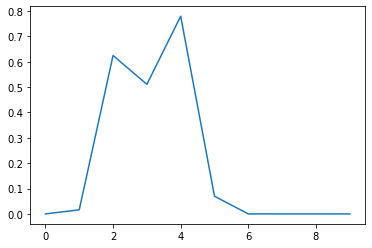

In [26]:
plt.figure()
plt.plot(h)

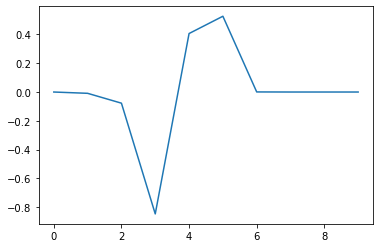

In [29]:
plt.figure()
plt.plot(jac_h[:, 1])